In [115]:
import os
import sys
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

In [116]:
img_size = 200
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False

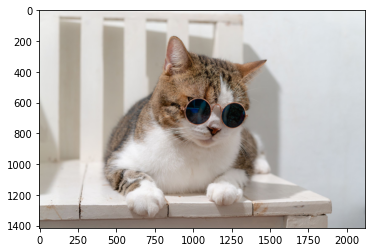

In [131]:
content_image = Image.open('content.jpg')
imshow(content_image)

In [118]:
def compute_content_cost(content_output, generated_output):
    """
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) 
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

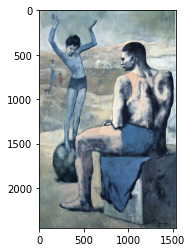

In [119]:
style = Image.open('style.jpg')
imshow(style)

In [120]:
def gram_matrix(A):
    """
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [122]:
def compute_layer_style_cost(a_S, a_G):
    """
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    return J_style_layer

In [123]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [124]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [125]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 12, 12, 512) dtype=float32 (created by layer 'block5_conv4')>

In [126]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [127]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Returns: 
    J_style -- tensor representing a scalar value
    """
    J_style = 0

    a_S = style_image_output[1:]
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

In [128]:

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Returns:
    J -- total cost
    """
    J = alpha * J_content + beta * J_style

    return J

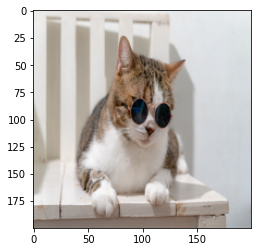

In [163]:
content_image = np.array(Image.open('content.jpg').resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape))) # add batch-dim
imshow(content_image[0])
# content_image = Image.open('content.jpg')
# content_image = np.array(content_image)
# content_image = tf.convert_to_tensor(content_image, tf.uint8)
# content_image = tf.image.convert_image_dtype(content_image, tf.float32)
# content_image = tf.image.resize(content_image, [200, 200])
# content_image = content_image[np.newaxis, :]
# print(content_image.shape)
# imshow(content_image[0])

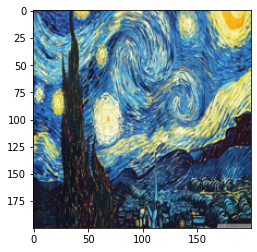

In [164]:
style_image = np.array(Image.open('style.jpg').resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape))) # add batch-dim
imshow(style_image[0]) 


# style_image = Image.open('style.jpg')
# style_image = np.array(style_image)
# style_image = tf.convert_to_tensor(style_image, tf.uint8)
# style_image = tf.image.convert_image_dtype(style_image, tf.float32)
# style_image = tf.image.resize(style_image, [200, 200])
# style_image = style_image[np.newaxis, :]
# print(style_image.shape)
# imshow(style_image[0])

(1, 200, 200, 3)


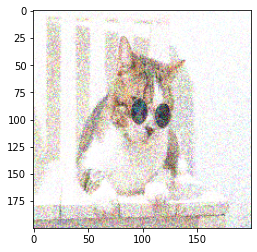

In [165]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])

In [140]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [141]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [166]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [143]:
def clip_image_float(image):
    return tf.clip_by_value(image, 0.0, 1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [167]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

a_G = vgg_model_outputs(generated_image)

J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008333741, shape=(), dtype=float32)


In [168]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(3436.3525, shape=(), dtype=float32)


In [169]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
    
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
    # For grading purposes
    return J

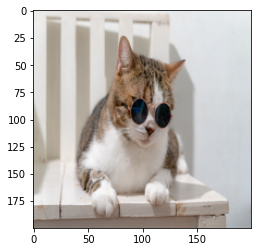

In [170]:
imshow(content_image[0])

Epoch 0 


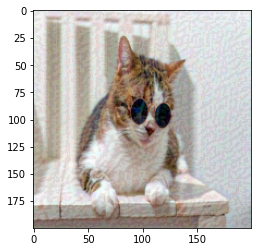

Epoch 10 


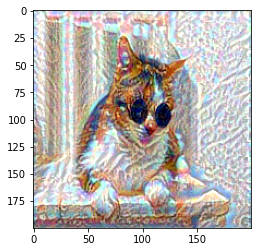

Epoch 20 


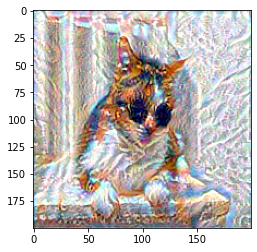

Epoch 30 


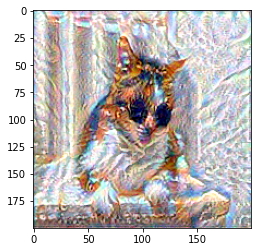

Epoch 40 


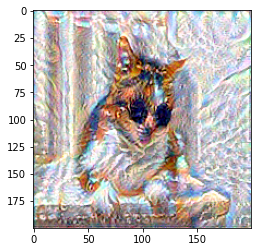

Epoch 50 


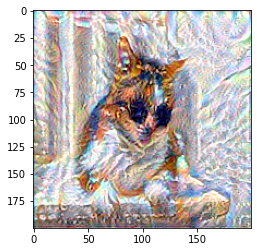

Epoch 60 


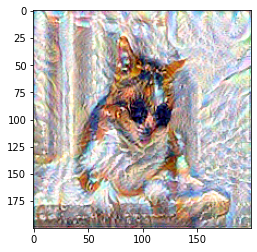

Epoch 70 


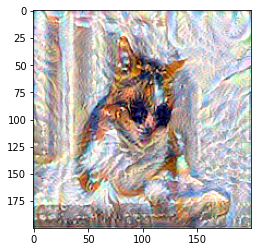

Epoch 80 


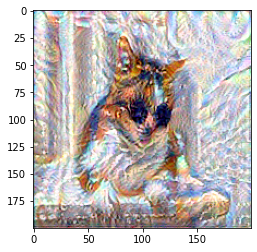

Epoch 90 


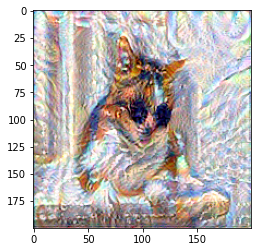

In [171]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 100
for i in range(epochs):
    train_step(generated_image, alpha=100, beta=100)
    if i % 10 == 0:
        print(f"Epoch {i} ")
    if i % 10 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"images/{i}.jpg")
        plt.show()